# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.00546075 -0.19225212  0.02491829  0.33119934] 0 1.0 False {}
state, action, reward, done, info
[-0.00930579  0.00250643  0.03154228  0.04647742] 1 1.0 False {}
state, action, reward, done, info
[-0.00925567  0.19716222  0.03247183 -0.23608913] 1 1.0 False {}
state, action, reward, done, info
[-0.00531242  0.00159175  0.02775004  0.06665696] 0 1.0 False {}
state, action, reward, done, info
[-0.00528059  0.19630508  0.02908318 -0.21714312] 1 1.0 False {}
state, action, reward, done, info
[-0.00135448  0.39099946  0.02474032 -0.50051194] 1 1.0 False {}
state, action, reward, done, info
[ 0.0064655   0.58576407  0.01473008 -0.78529654] 1 1.0 False {}
state, action, reward, done, info
[ 1.81807860e-02  7.80680571e-01 -9.75848625e-04 -1.07330908e+00] 1 1.0 False {}
state, action, reward, done, info
[ 0.0337944   0.97581541 -0.02244203 -1.36629809] 1 1.0 False {}
state, action, reward, done, info
[ 0.05331071  1.17121103 -0.04976799 -1.66591513] 1 1.0 Fal

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1712110337046753 -1.6659151327343995


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name=None)
    actions = tf.placeholder(tf.int32, [None], name=None)

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name=None)
    return states, actions, targetQs

In [6]:
def generator(states, hidden_size, action_size, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(0.01 * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(0.01 * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(nl2, action_size)
        # out = tf.tanh(logits)

        return logits

In [7]:
def model_loss(states, hidden_size, actions, action_size, targetQs):
    # Output layer
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)        

    # One hot encode the actions to later choose the Q-value for the action
    actions_labels = tf.one_hot(actions, action_size)

    # Train with loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_labels), axis=1)

    # error backpropagation: loss and opt
    loss = tf.reduce_mean(tf.square(targetQs - Qs))
    
    return actions_logits, Qs, loss

In [8]:
class DQN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):
        
        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs, self.loss = model_loss(action_size=action_size, actions=self.actions, 
                                                      states=self.states, hidden_size=hidden_size, 
                                                      targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [9]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 400               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
learning_rate = 0.001

In [11]:
tf.reset_default_graph()
model = DQN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [12]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    # Episode is done/failed or not;
    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [13]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from DQN
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            next_actions_logits = sess.run(model.actions_logits, feed_dict={model.states: next_states})

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation
            targetQs = rewards + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            loss, _ = sess.run([model.loss, model.opt],
                                feed_dict={model.states: states,
                                           model.targetQs: targetQs,
                                           model.actions: actions})
    # Save the trained model 
    saver.save(sess, "checkpoints/DQN-cartpole.ckpt")

Episode: 0 Total reward: 4.0 Training loss: 1.1609 Explore P: 0.9996
Episode: 1 Total reward: 18.0 Training loss: 1.3603 Explore P: 0.9978
Episode: 2 Total reward: 17.0 Training loss: 1.3856 Explore P: 0.9961
Episode: 3 Total reward: 38.0 Training loss: 2.3256 Explore P: 0.9924
Episode: 4 Total reward: 60.0 Training loss: 55.8199 Explore P: 0.9865
Episode: 5 Total reward: 17.0 Training loss: 47.1340 Explore P: 0.9849
Episode: 6 Total reward: 13.0 Training loss: 7.8965 Explore P: 0.9836
Episode: 7 Total reward: 17.0 Training loss: 10.4280 Explore P: 0.9820
Episode: 8 Total reward: 15.0 Training loss: 38.7427 Explore P: 0.9805
Episode: 9 Total reward: 34.0 Training loss: 48.6849 Explore P: 0.9772
Episode: 10 Total reward: 36.0 Training loss: 4.7511 Explore P: 0.9737
Episode: 11 Total reward: 11.0 Training loss: 86.6790 Explore P: 0.9727
Episode: 12 Total reward: 9.0 Training loss: 7.5676 Explore P: 0.9718
Episode: 13 Total reward: 9.0 Training loss: 178.5213 Explore P: 0.9709
Episode: 14

Episode: 117 Total reward: 34.0 Training loss: 63.3709 Explore P: 0.6985
Episode: 118 Total reward: 22.0 Training loss: 934.9377 Explore P: 0.6970
Episode: 119 Total reward: 100.0 Training loss: 138.0240 Explore P: 0.6901
Episode: 120 Total reward: 11.0 Training loss: 1104.4958 Explore P: 0.6894
Episode: 121 Total reward: 22.0 Training loss: 76.3128 Explore P: 0.6879
Episode: 122 Total reward: 9.0 Training loss: 55.4725 Explore P: 0.6873
Episode: 123 Total reward: 31.0 Training loss: 801.6287 Explore P: 0.6852
Episode: 124 Total reward: 16.0 Training loss: 83.2106 Explore P: 0.6841
Episode: 125 Total reward: 34.0 Training loss: 65.6132 Explore P: 0.6818
Episode: 126 Total reward: 46.0 Training loss: 68.9152 Explore P: 0.6787
Episode: 127 Total reward: 44.0 Training loss: 86.9923 Explore P: 0.6758
Episode: 128 Total reward: 107.0 Training loss: 99.3586 Explore P: 0.6687
Episode: 129 Total reward: 129.0 Training loss: 534.8941 Explore P: 0.6603
Episode: 130 Total reward: 33.0 Training lo

Episode: 227 Total reward: 199.0 Training loss: 11.0028 Explore P: 0.1644
Episode: 228 Total reward: 199.0 Training loss: 3477.1328 Explore P: 0.1613
Episode: 229 Total reward: 193.0 Training loss: 24.1058 Explore P: 0.1584
Episode: 230 Total reward: 199.0 Training loss: 27.0360 Explore P: 0.1555
Episode: 231 Total reward: 199.0 Training loss: 14.3196 Explore P: 0.1527
Episode: 232 Total reward: 199.0 Training loss: 19.2689 Explore P: 0.1498
Episode: 233 Total reward: 199.0 Training loss: 8.4058 Explore P: 0.1471
Episode: 234 Total reward: 199.0 Training loss: 32.2361 Explore P: 0.1444
Episode: 235 Total reward: 161.0 Training loss: 39.1910 Explore P: 0.1422
Episode: 236 Total reward: 133.0 Training loss: 308.8845 Explore P: 0.1405
Episode: 237 Total reward: 17.0 Training loss: 111.2985 Explore P: 0.1403
Episode: 238 Total reward: 13.0 Training loss: 144.7335 Explore P: 0.1401
Episode: 239 Total reward: 14.0 Training loss: 140.8874 Explore P: 0.1399
Episode: 240 Total reward: 97.0 Trai

Episode: 338 Total reward: 199.0 Training loss: 24.8687 Explore P: 0.0327
Episode: 339 Total reward: 146.0 Training loss: 7.0969 Explore P: 0.0324
Episode: 340 Total reward: 199.0 Training loss: 1.7227 Explore P: 0.0319
Episode: 341 Total reward: 129.0 Training loss: 2535.7788 Explore P: 0.0317
Episode: 342 Total reward: 50.0 Training loss: 77.9195 Explore P: 0.0316
Episode: 343 Total reward: 10.0 Training loss: 5696.2139 Explore P: 0.0315
Episode: 344 Total reward: 9.0 Training loss: 25.1706 Explore P: 0.0315
Episode: 345 Total reward: 10.0 Training loss: 5389.7822 Explore P: 0.0315
Episode: 346 Total reward: 14.0 Training loss: 95.4914 Explore P: 0.0315
Episode: 347 Total reward: 9.0 Training loss: 100.4664 Explore P: 0.0314
Episode: 348 Total reward: 11.0 Training loss: 41.9807 Explore P: 0.0314
Episode: 349 Total reward: 19.0 Training loss: 55.7984 Explore P: 0.0314
Episode: 350 Total reward: 10.0 Training loss: 33.7849 Explore P: 0.0314
Episode: 351 Total reward: 199.0 Training lo

Episode: 450 Total reward: 199.0 Training loss: 34.0020 Explore P: 0.0146
Episode: 451 Total reward: 175.0 Training loss: 60.1475 Explore P: 0.0145
Episode: 452 Total reward: 199.0 Training loss: 10.5374 Explore P: 0.0144
Episode: 453 Total reward: 199.0 Training loss: 11.3610 Explore P: 0.0143
Episode: 454 Total reward: 155.0 Training loss: 11.7890 Explore P: 0.0143
Episode: 455 Total reward: 175.0 Training loss: 88.2346 Explore P: 0.0142
Episode: 456 Total reward: 199.0 Training loss: 27.1504 Explore P: 0.0141
Episode: 457 Total reward: 199.0 Training loss: 6.8198 Explore P: 0.0140
Episode: 458 Total reward: 199.0 Training loss: 6.0963 Explore P: 0.0139
Episode: 459 Total reward: 199.0 Training loss: 4.8352 Explore P: 0.0139
Episode: 460 Total reward: 199.0 Training loss: 4.9164 Explore P: 0.0138
Episode: 461 Total reward: 187.0 Training loss: 6.0045 Explore P: 0.0137
Episode: 462 Total reward: 131.0 Training loss: 97.7450 Explore P: 0.0137
Episode: 463 Total reward: 129.0 Training l

Episode: 564 Total reward: 7.0 Training loss: 58.9710 Explore P: 0.0107
Episode: 565 Total reward: 9.0 Training loss: 114.6398 Explore P: 0.0107
Episode: 566 Total reward: 10.0 Training loss: 42.3863 Explore P: 0.0107
Episode: 567 Total reward: 8.0 Training loss: 31.1409 Explore P: 0.0107
Episode: 568 Total reward: 11.0 Training loss: 79.8401 Explore P: 0.0107
Episode: 569 Total reward: 9.0 Training loss: 326.9276 Explore P: 0.0107
Episode: 570 Total reward: 9.0 Training loss: 337.6254 Explore P: 0.0107
Episode: 571 Total reward: 7.0 Training loss: 382.4323 Explore P: 0.0107
Episode: 572 Total reward: 8.0 Training loss: 94.0491 Explore P: 0.0107
Episode: 573 Total reward: 10.0 Training loss: 516.8513 Explore P: 0.0107
Episode: 574 Total reward: 10.0 Training loss: 64.3701 Explore P: 0.0107
Episode: 575 Total reward: 8.0 Training loss: 130.2975 Explore P: 0.0107
Episode: 576 Total reward: 12.0 Training loss: 276.2094 Explore P: 0.0107
Episode: 577 Total reward: 7.0 Training loss: 264.45

Episode: 678 Total reward: 13.0 Training loss: 19.1578 Explore P: 0.0102
Episode: 679 Total reward: 83.0 Training loss: 4.3303 Explore P: 0.0102
Episode: 680 Total reward: 199.0 Training loss: 4.2329 Explore P: 0.0102
Episode: 681 Total reward: 199.0 Training loss: 2.2989 Explore P: 0.0102
Episode: 682 Total reward: 199.0 Training loss: 19.4359 Explore P: 0.0102
Episode: 683 Total reward: 199.0 Training loss: 3.3375 Explore P: 0.0102
Episode: 684 Total reward: 199.0 Training loss: 4.1484 Explore P: 0.0101
Episode: 685 Total reward: 199.0 Training loss: 1.0457 Explore P: 0.0101
Episode: 686 Total reward: 199.0 Training loss: 2.8912 Explore P: 0.0101
Episode: 687 Total reward: 199.0 Training loss: 2.8104 Explore P: 0.0101
Episode: 688 Total reward: 199.0 Training loss: 3.0112 Explore P: 0.0101
Episode: 689 Total reward: 173.0 Training loss: 1.7477 Explore P: 0.0101
Episode: 690 Total reward: 199.0 Training loss: 4.6408 Explore P: 0.0101
Episode: 691 Total reward: 199.0 Training loss: 2.2

Episode: 790 Total reward: 199.0 Training loss: 723.0733 Explore P: 0.0100
Episode: 791 Total reward: 199.0 Training loss: 9.3367 Explore P: 0.0100
Episode: 792 Total reward: 199.0 Training loss: 8.6341 Explore P: 0.0100
Episode: 793 Total reward: 199.0 Training loss: 9.5582 Explore P: 0.0100
Episode: 794 Total reward: 199.0 Training loss: 11.3614 Explore P: 0.0100
Episode: 795 Total reward: 199.0 Training loss: 49.9524 Explore P: 0.0100
Episode: 796 Total reward: 199.0 Training loss: 4.0898 Explore P: 0.0100
Episode: 797 Total reward: 169.0 Training loss: 12.3545 Explore P: 0.0100
Episode: 798 Total reward: 199.0 Training loss: 24.0304 Explore P: 0.0100
Episode: 799 Total reward: 199.0 Training loss: 7.8608 Explore P: 0.0100
Episode: 800 Total reward: 199.0 Training loss: 16.1385 Explore P: 0.0100
Episode: 801 Total reward: 199.0 Training loss: 3.9600 Explore P: 0.0100
Episode: 802 Total reward: 199.0 Training loss: 14.2697 Explore P: 0.0100
Episode: 803 Total reward: 199.0 Training l

Episode: 904 Total reward: 9.0 Training loss: 67.4470 Explore P: 0.0100
Episode: 905 Total reward: 118.0 Training loss: 7.5617 Explore P: 0.0100
Episode: 906 Total reward: 199.0 Training loss: 520.6476 Explore P: 0.0100
Episode: 907 Total reward: 199.0 Training loss: 5.7994 Explore P: 0.0100
Episode: 908 Total reward: 189.0 Training loss: 1.7199 Explore P: 0.0100
Episode: 909 Total reward: 199.0 Training loss: 2.4482 Explore P: 0.0100
Episode: 910 Total reward: 199.0 Training loss: 5.4117 Explore P: 0.0100
Episode: 911 Total reward: 199.0 Training loss: 4.3188 Explore P: 0.0100
Episode: 912 Total reward: 160.0 Training loss: 8.4529 Explore P: 0.0100
Episode: 913 Total reward: 165.0 Training loss: 8.2118 Explore P: 0.0100
Episode: 914 Total reward: 128.0 Training loss: 2.0601 Explore P: 0.0100
Episode: 915 Total reward: 133.0 Training loss: 5.7167 Explore P: 0.0100
Episode: 916 Total reward: 96.0 Training loss: 3.0576 Explore P: 0.0100
Episode: 917 Total reward: 199.0 Training loss: 3.7

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

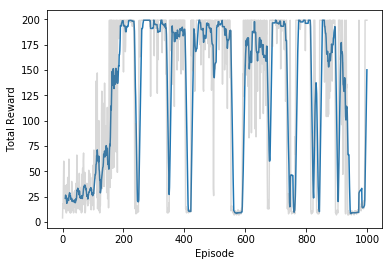

In [15]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

Text(0,0.5,'Training Loss')

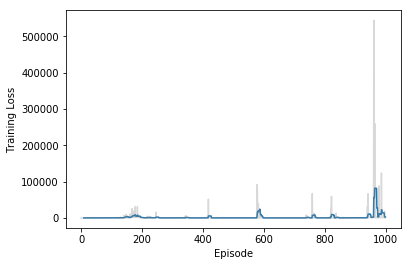

In [16]:
eps, loss = np.array(loss_list).T
smoothed_loss = running_mean(loss, 10)
plt.plot(eps[-len(smoothed_loss):], smoothed_loss)
plt.plot(eps, loss, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Training Loss')

## Testing

Let's checkout how our trained agent plays the game.

In [17]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Restore/load the trained model 
    saver.restore(sess, "checkpoints/DQN-cartpole.ckpt")
    
    # Training episodes/ epochs
    for ep in range(test_episodes):
        
        # Env/Rob steps for minibatches/batches training
        t = 0
        while t < test_max_steps:
            # env.render() 
            
            # Get action from DQN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # If episode is done/failed;
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQN-cartpole.ckpt


In [18]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.